# **Import Library**

In [1]:
from keras.utils import to_categorical
from nltk.corpus import stopwords # Daftar kata-kata berhenti dalam teks
from nltk.stem import PorterStemmer # Stemmer yang digunakan adalah Porter Stemmer.
from nltk.tokenize import word_tokenize # Tokenisasi teks
from sklearn.feature_extraction.text import TfidfVectorizer # Konversi teks menjadi vektor TF-IDF
from sklearn.model_selection import train_test_split # Membagi data menjadi set pelatihan dan pengujian
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt # Matplotlib untuk visualisasi data
import nltk # Import pustaka NLTK (Natural Language Toolkit).
import numpy as np # NumPy untuk komputasi numerik
import pandas as pd # Pandas untuk manipulasi dan analisis data
import re # Modul untuk bekerja dengan ekspresi reguler
import seaborn as sns # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
import string # Berisi konstanta string, seperti tanda baca
import tensorflow as tf
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stop words) dalam berbagai bahasa.
np.random.seed(0) # Mengatur seed untuk reproduktibilitas
pd.options.mode.chained_assignment = None # Menonaktifkan peringatan chaining

2024-07-22 21:44:20.671604: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 21:44:20.675794: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 21:44:20.688711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 21:44:20.709870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 21:44:20.715855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 21:44:20.729996: I tensorflow/core/platform/cpu_feature_gu

## Preprocessing

In [2]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('english'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    stemmer = PorterStemmer()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in text]

    return stemmed_words

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

# Loading Dataset

In [3]:
balanced_df = pd.read_csv('balanced_reviews.csv') # Load dataset
balanced_df.head(1)

,content,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_stemmingText,text_akhir,polarity,label
0,Game is very fun and helps you learn about pla...,Game is very fun and helps you learn about pla...,game is very fun and helps you learn about pla...,"['game', 'is', 'very', 'fun', 'and', 'helps', ...","['game', 'fun', 'helps', 'learn', 'playing', '...","['game', 'fun', 'help', 'learn', 'play', 'game...",game fun help learn play game real rig opinion...,0.088889,pos


# Count Vectorizer

In [4]:
# Create a mapping from label strings to integers
label_mapping = {'neg': 0, 'neutral': 1, 'pos': 2}
balanced_df['label'] = balanced_df['label'].map(label_mapping)

In [5]:
balanced_df.value_counts('label')

label
0    8000
1    8000
2    8000
Name: count, dtype: int64

In [6]:
balanced_df['text_akhir'] = balanced_df['text_akhir'].fillna('')

In [7]:
# Membuat objek TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer()  # Limit the number of features
tfidf_vectorizer = TfidfVectorizer(max_features=250)  # Limit the number of features
X = tfidf_vectorizer.fit_transform(balanced_df['text_akhir'])

In [8]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,abl,absolut,account,actual,ad,add,addict,aim,allow,almost,...,well,wheel,win,without,wont,work,worst,would,year,your
0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.159875,0.0,0.0,0.00000,0.187632
1,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.124079,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000
2,0.00000,0.0,0.184818,0.000000,0.0,0.0,0.0,0.0,0.0,0.209737,...,0.0,0.0,0.368507,0.186178,0.00000,0.000000,0.0,0.0,0.00000,0.000000
3,0.00000,0.0,0.198745,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.18436,0.000000
4,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000
23996,0.17669,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.180868
23997,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.28105,0.000000,0.0,0.0,0.00000,0.000000
23998,0.00000,0.0,0.000000,0.188301,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000


In [9]:
# Membagi data menjadi set pelatihan dan pengujian (70% data pelatihan, 30% data pengujian)
X_train, X_test, y_train, y_test = train_test_split(X, balanced_df['label'], test_size=0.3, random_state=42)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Menampilkan dimensi set pelatihan dan pengujian
print("Dimensi set pelatihan:", X_train.shape)
print("Dimensi set pengujian:", X_test.shape)

Dimensi set pelatihan: (16800, 250)
Dimensi set pengujian: (7200, 250)


### LSTM

In [10]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

In [11]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/home/bima/Documents/8BallPool_Sentiment_Analysis/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1721659496.359771   28679 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-22 21:44:56.360382: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 53s 212ms/step - accuracy: 0.3268 - loss: 1.1001 - val_accuracy: 0.3185 - val_loss: 1.0997
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 49s 206ms/step - accuracy: 0.3430 - loss: 1.0984 - val_accuracy: 0.3446 - val_loss: 1.0984
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 208ms/step - accuracy: 0.3372 - loss: 1.0990 - val_accuracy: 0.3446 - val_loss: 1.0982
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 61s 258ms/step - accuracy: 0.3337 - loss: 1.0989 - val_accuracy: 0.3185 - val_loss: 1.0989
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 64s 271ms/step - accuracy: 0.3367 - loss: 1.0988 - val_accuracy: 0.3185 - val_loss: 1.0990


In [12]:
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.3249 - loss: 1.0989
Test set
  Loss: 1.099
  Accuracy: 0.334


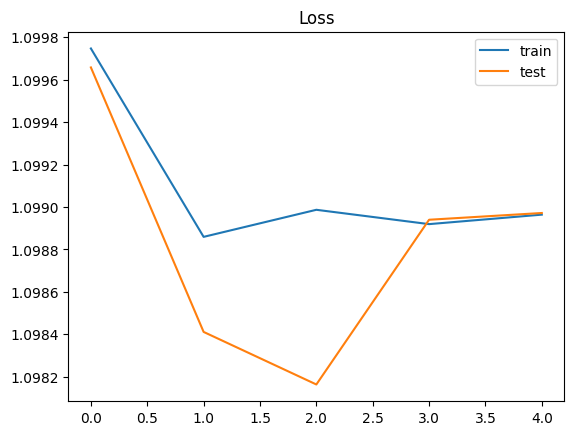

In [13]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

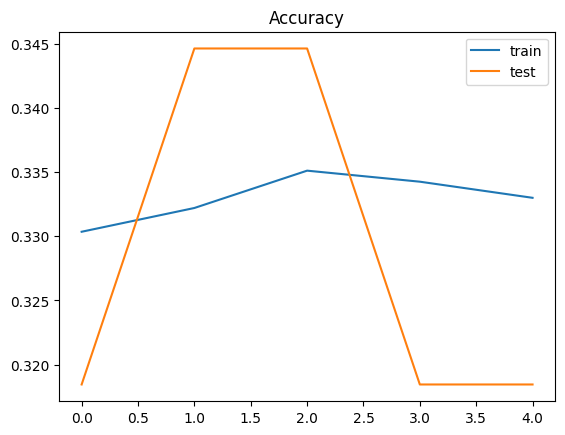

In [14]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [15]:
new_review = ['''Very upsetting, I had a few million coins when the dang game started glitching, I would make a shot and the game would glitch and you could clearly see that the shot went in but the screen would flàsh and the balls would be right back like they were before I shot. And the opponent would have ball in hand. Then for some ungodly reason the game restarted and almost all of my coins were gone!!!!! There should be some way to get them back since it was the game that took them. About ready to delete!!''']
seq = tfidf_vectorizer.transform(new_review)
prediction = model.predict(seq)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
[[0.3340141 0.3384769 0.3275091]]
